In [1]:
from st_utils import *
from MILWRM import *

# some stuff to make this notebook work better with Scanpy
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

---
### Read in Visium ST Anndata
This uses standard `scanpy` functions

In [2]:
prostate_cancer = sc.read("data/Visium_FFPE_Human_Prostate_Cancer_raw.h5ad"); prostate_cancer

AnnData object with n_obs × n_vars = 4992 × 18365
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'

In [3]:
prostate_adj_normal = sc.read("data/Visium_FFPE_Human_Prostate_IF_raw.h5ad"); prostate_adj_normal

AnnData object with n_obs × n_vars = 4992 × 18476
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'

In [4]:
prostate_normal = sc.read("data/Visium_FFPE_Human_Normal_Prostate_raw.h5ad"); prostate_normal

AnnData object with n_obs × n_vars = 4991 × 17991
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'

---
### Map ST data to histology pixels and trim images
This uses functions from `st_utils.py`

In [5]:
prostate_cancer = map_pixels(prostate_cancer, filter_label="in_tissue")

Creating pixel grid and mapping to nearest barcode coordinates
Saving barcode mapping to adata.uns['pixel_map_df'] and adding metadata
Filtering barcodes using labels in self.adata.obs['in_tissue']
New size: 4371 spots x 18365 genes
Done!


Cropping image to pixel dimensions and adding values to adata.uns['pixel_map_df']
Cropping Visium spot coordinates and saving to adata.obsm['spatial_trim']
Saving cropped and trimmed image to adata.uns['spatial']['Visium_FFPE_Human_Prostate_Cancer']['images']['hires_trim']
Plotting pita as RGB image
Done!


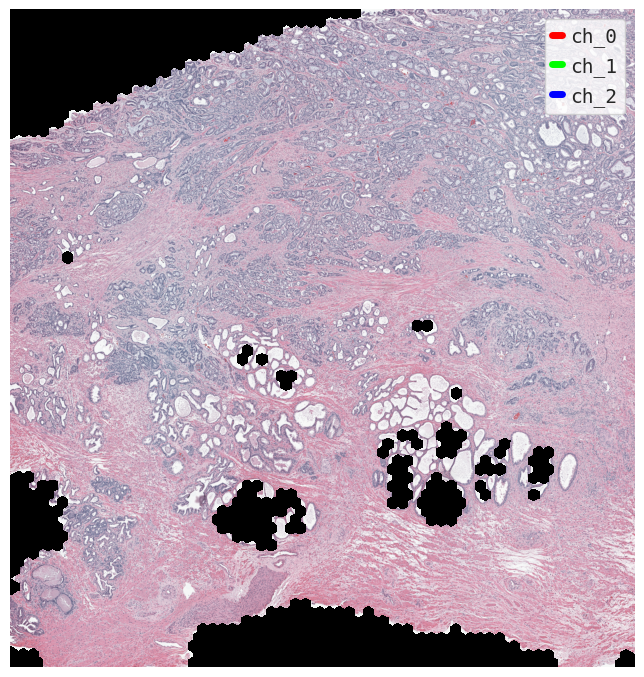

In [6]:
cancer_img = trim_image(prostate_cancer)

In [7]:
prostate_adj_normal = map_pixels(prostate_adj_normal, filter_label="in_tissue")

Creating pixel grid and mapping to nearest barcode coordinates
Saving barcode mapping to adata.uns['pixel_map_df'] and adding metadata
Filtering barcodes using labels in self.adata.obs['in_tissue']
New size: 3460 spots x 18476 genes
Done!


Cropping image to pixel dimensions and adding values to adata.uns['pixel_map_df']
Cropping Visium spot coordinates and saving to adata.obsm['spatial_trim']
Saving cropped and trimmed image to adata.uns['spatial']['Visium_FFPE_Human_Prostate_IF']['images']['hires_trim']
Plotting pita as RGB image
Done!


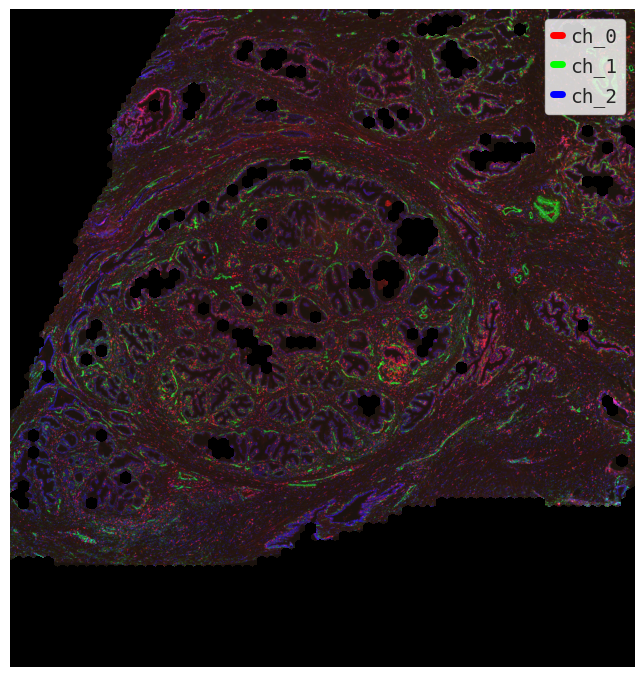

In [8]:
adj_normal_img = trim_image(prostate_adj_normal)

In [9]:
prostate_normal = map_pixels(prostate_normal, filter_label="in_tissue")

Creating pixel grid and mapping to nearest barcode coordinates
Saving barcode mapping to adata.uns['pixel_map_df'] and adding metadata
Filtering barcodes using labels in self.adata.obs['in_tissue']
New size: 2543 spots x 17991 genes
Done!


Cropping image to pixel dimensions and adding values to adata.uns['pixel_map_df']
Cropping Visium spot coordinates and saving to adata.obsm['spatial_trim']
Saving cropped and trimmed image to adata.uns['spatial']['Visium_FFPE_Human_Normal_Prostate']['images']['hires_trim']
Plotting pita as RGB image
Done!


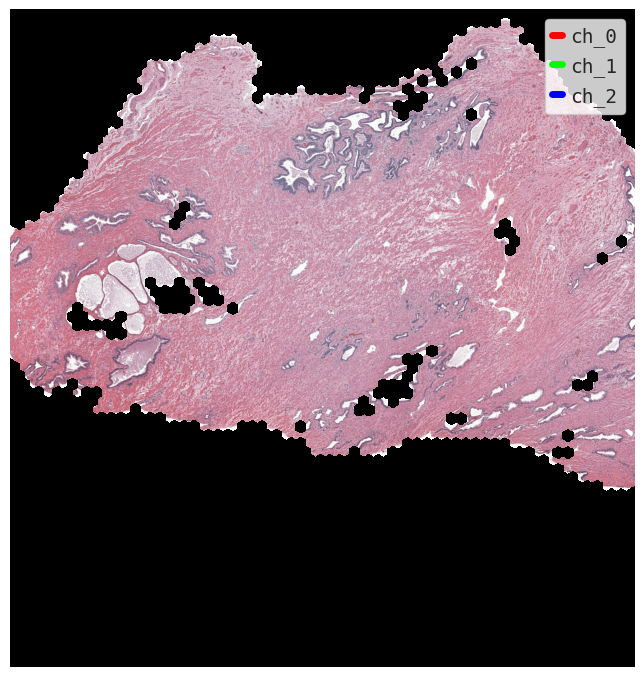

In [10]:
normal_img = trim_image(prostate_normal)

---
### Perform joint PCA to get a low-dimensional space for clustering
Again, standard `scanpy`/`anndata` functions here

In [11]:
prostate_comb = prostate_cancer.concatenate([prostate_adj_normal, prostate_normal], fill_value=0, join="outer"); prostate_comb

AnnData object with n_obs × n_vars = 10374 × 19071
    obs: 'in_tissue', 'array_row', 'array_col', 'batch'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2'
    obsm: 'spatial', 'spatial_trim', 'image_means'

In [12]:
sc.pp.normalize_total(prostate_comb)
sc.pp.log1p(prostate_comb)
sc.pp.scale(prostate_comb)
sc.pp.pca(prostate_comb, n_comps=50)

... storing 'gene_ids-0' as categorical
... storing 'gene_ids-1' as categorical
... storing 'gene_ids-2' as categorical


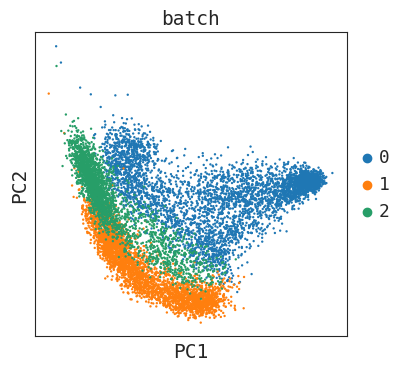

/Users/cody/.virtualenvs/sc/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/cody/.virtualenvs/sc/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0, flags=flags)


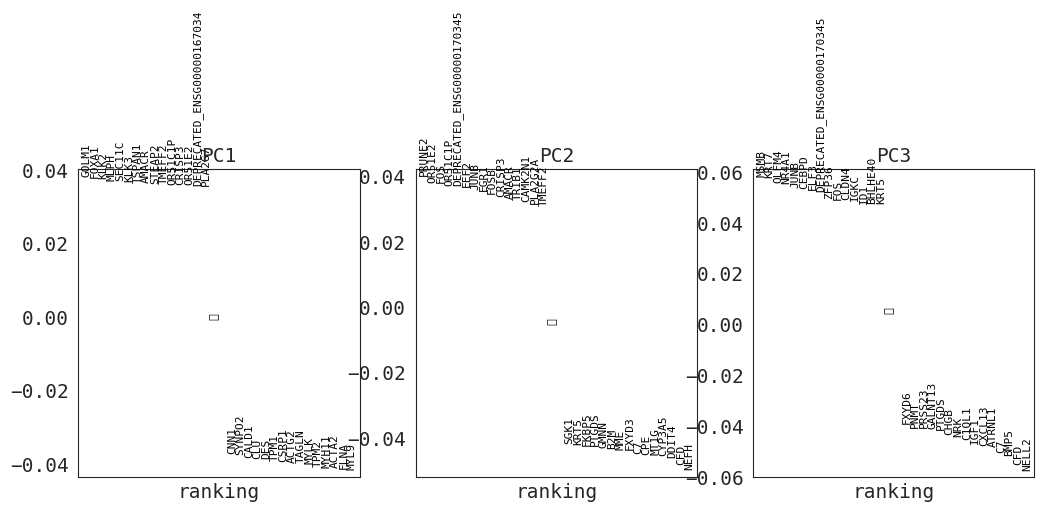

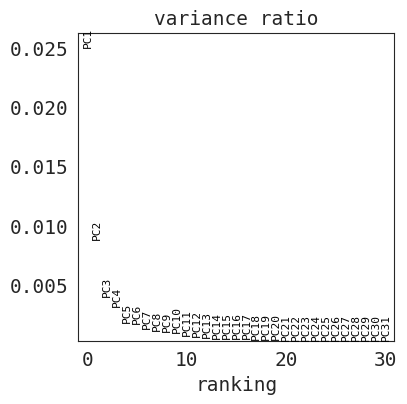

In [13]:
sc.pl.pca_overview(prostate_comb, color="batch")

In [14]:
# add PCA coordinates to original anndata objects
prostate_cancer.obsm["X_pca"] = prostate_comb[prostate_comb.obs.batch=="0",:].obsm["X_pca"]
prostate_adj_normal.obsm["X_pca"] = prostate_comb[prostate_comb.obs.batch=="1",:].obsm["X_pca"]
prostate_normal.obsm["X_pca"] = prostate_comb[prostate_comb.obs.batch=="2",:].obsm["X_pca"]

---
### Create `st_labeler` object and define macro clusters based on transcriptomics and histology
This comes from `H2TL.py`

In [15]:
tl = st_labeler([prostate_cancer, prostate_adj_normal, prostate_normal])

Initiating ST labeler with 3 anndata objects


#### Since the imaging data in the three sections are different (section 2 is fluorscence while sections 1 and 3 are brightfield histology), we'll exclude imaging features from the clustering model

In [16]:
%time tl.prep_cluster_data(use_rep="X_pca", features=[0,1,2,3,4], blur_pix=2)

Blurring training features for adata #0
Blurring training features for adata #1
Blurring training features for adata #2
Collected clustering data of shape: (10374, 5)
CPU times: user 1min 1s, sys: 91.1 ms, total: 1min 1s
Wall time: 1min 1s


#### We'll determine the optimal number of tissue regions by scaled inertia
If we want more clusters here, we can make the `alpha` penalty value smaller. If we want fewer clusters, we'll make it larger. The default value is `alpha=0.05`.

Determining optimal cluster number k via scaled inertia


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  19 | elapsed:    2.9s remaining:   24.5s
[Parallel(n_jobs=-1)]: Done   4 out of  19 | elapsed:    3.0s remaining:   11.1s
[Parallel(n_jobs=-1)]: Done   6 out of  19 | elapsed:    3.1s remaining:    6.6s
[Parallel(n_jobs=-1)]: Done   8 out of  19 | elapsed:    3.2s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done  10 out of  19 | elapsed:    3.3s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  12 out of  19 | elapsed:    3.6s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  14 out of  19 | elapsed:    3.7s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  16 out of  19 | elapsed:    3.7s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    3.9s finished


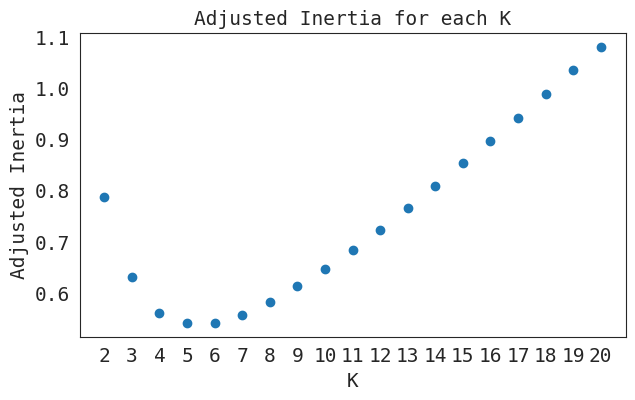

The optimal number of clusters is 6
Performing k-means clustering with 6 target clusters
Adding tissue_ID label to anndata objects
CPU times: user 1.18 s, sys: 493 ms, total: 1.67 s
Wall time: 4.23 s


In [17]:
%time tl.label_tissue_regions(plot_out=True, alpha=0.05)

#### Now show the features used for clustering after spatial blurring along with the final `tissue_ID` in each section

Assembling pita with 6 features from adata.obs
Casting barcodes to pixel dimensions and saving to adata.uns['pixel_map']
Done!
Assembling pita with 6 features from adata.obs
Casting barcodes to pixel dimensions and saving to adata.uns['pixel_map']
Done!
Assembling pita with 6 features from adata.obs
Casting barcodes to pixel dimensions and saving to adata.uns['pixel_map']
Done!


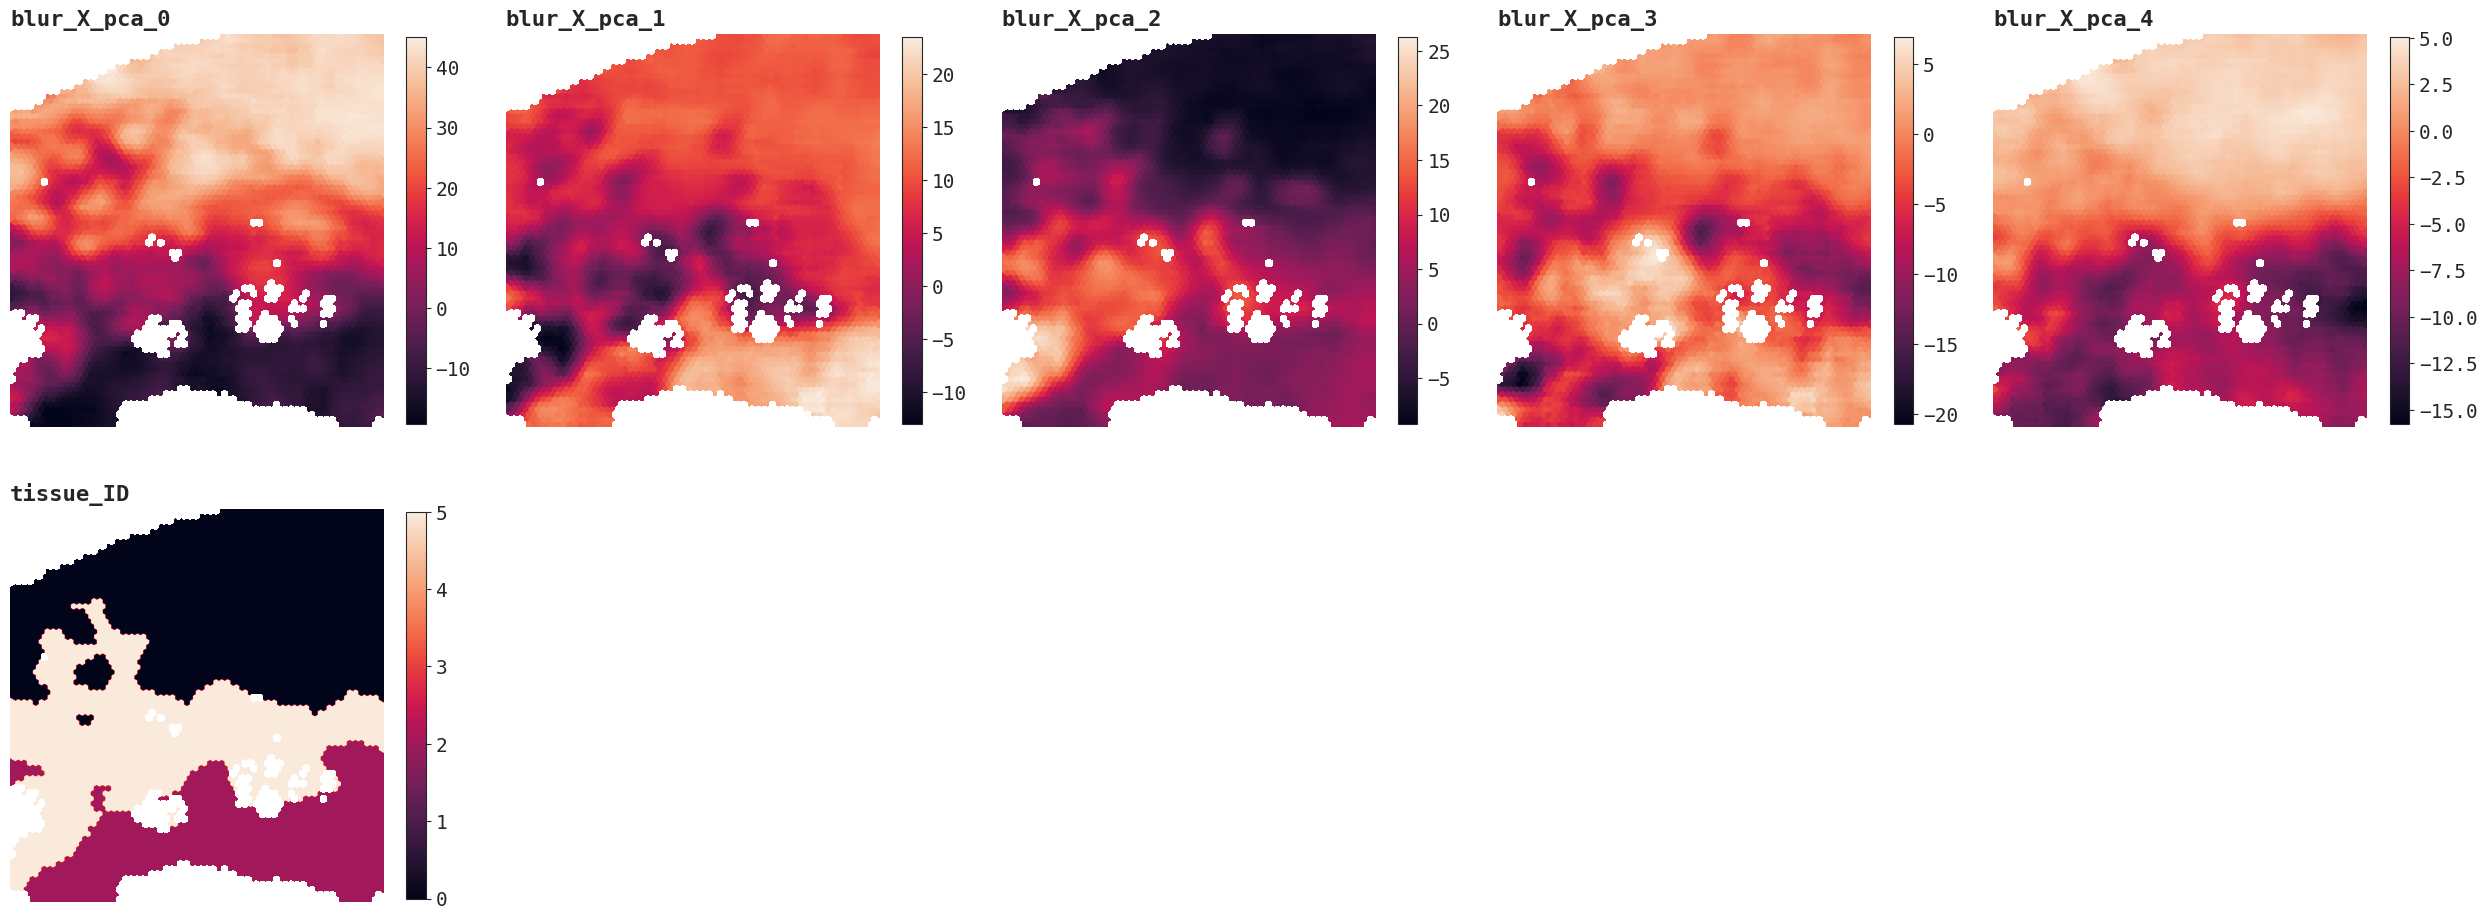

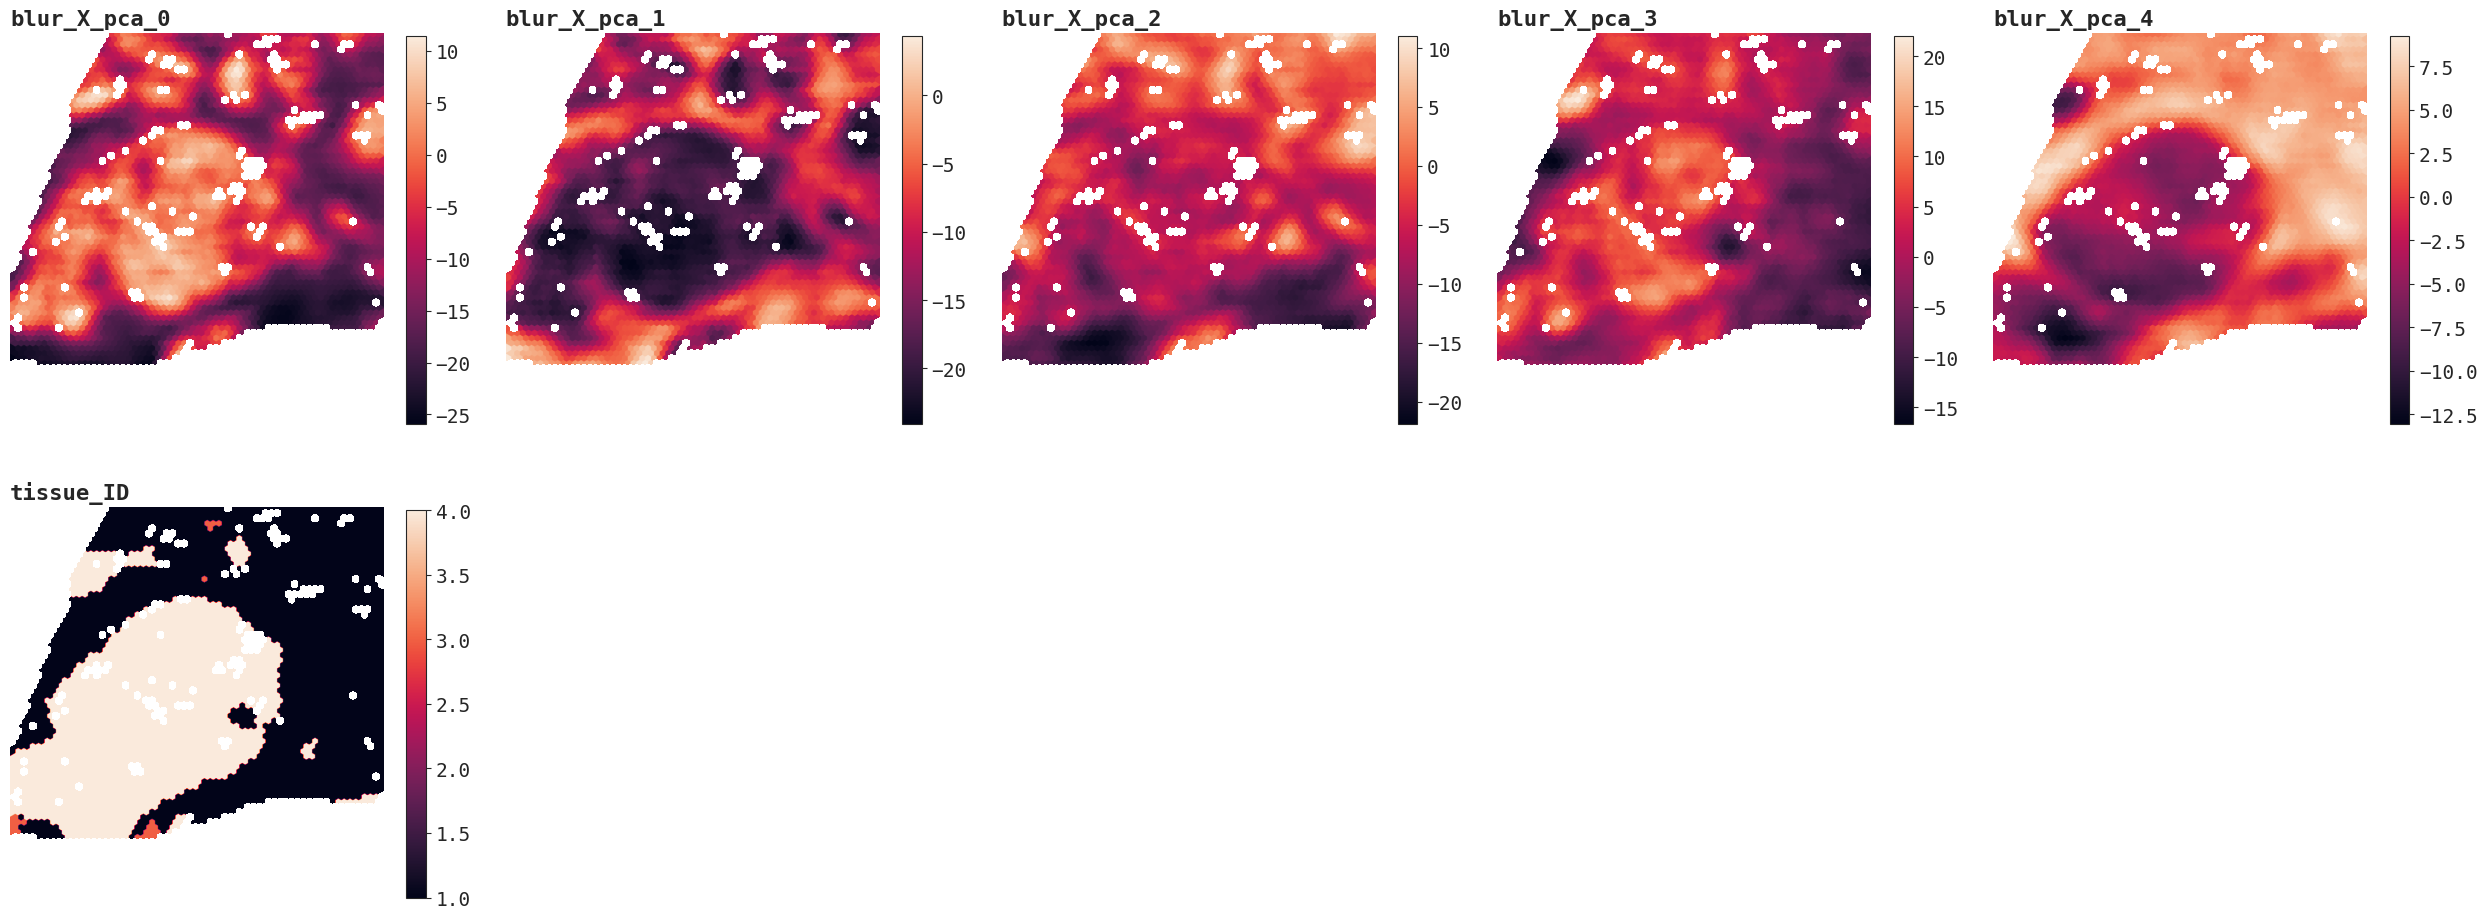

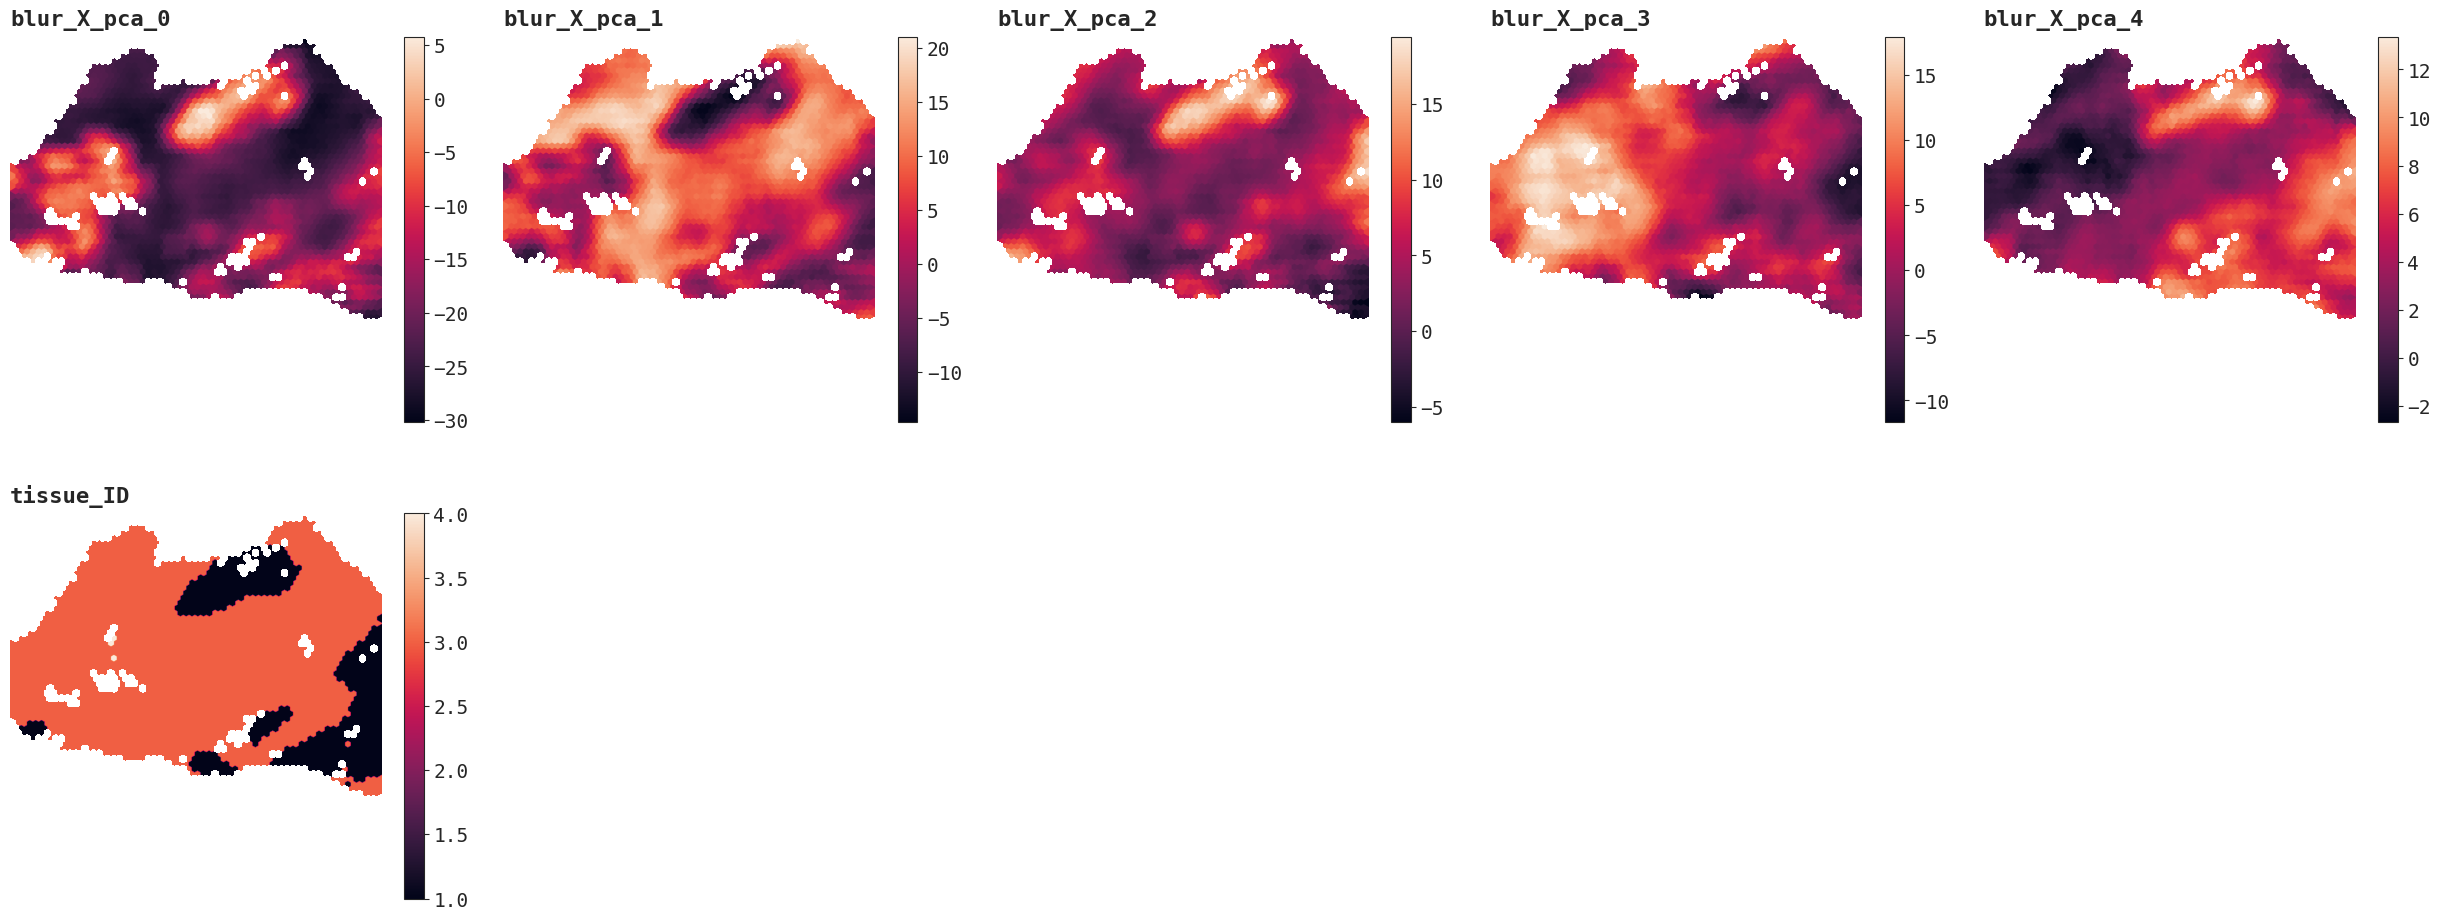

In [18]:
for i in range(len(tl.adatas)):
    n = list(tl.adatas[i].obs.columns[tl.adatas[i].obs.columns.str.startswith("blur_")]) + ["tissue_ID"]
    p = assemble_pita(tl.adatas[i], use_rep=".obs", features=n, ncols=5, label=n)

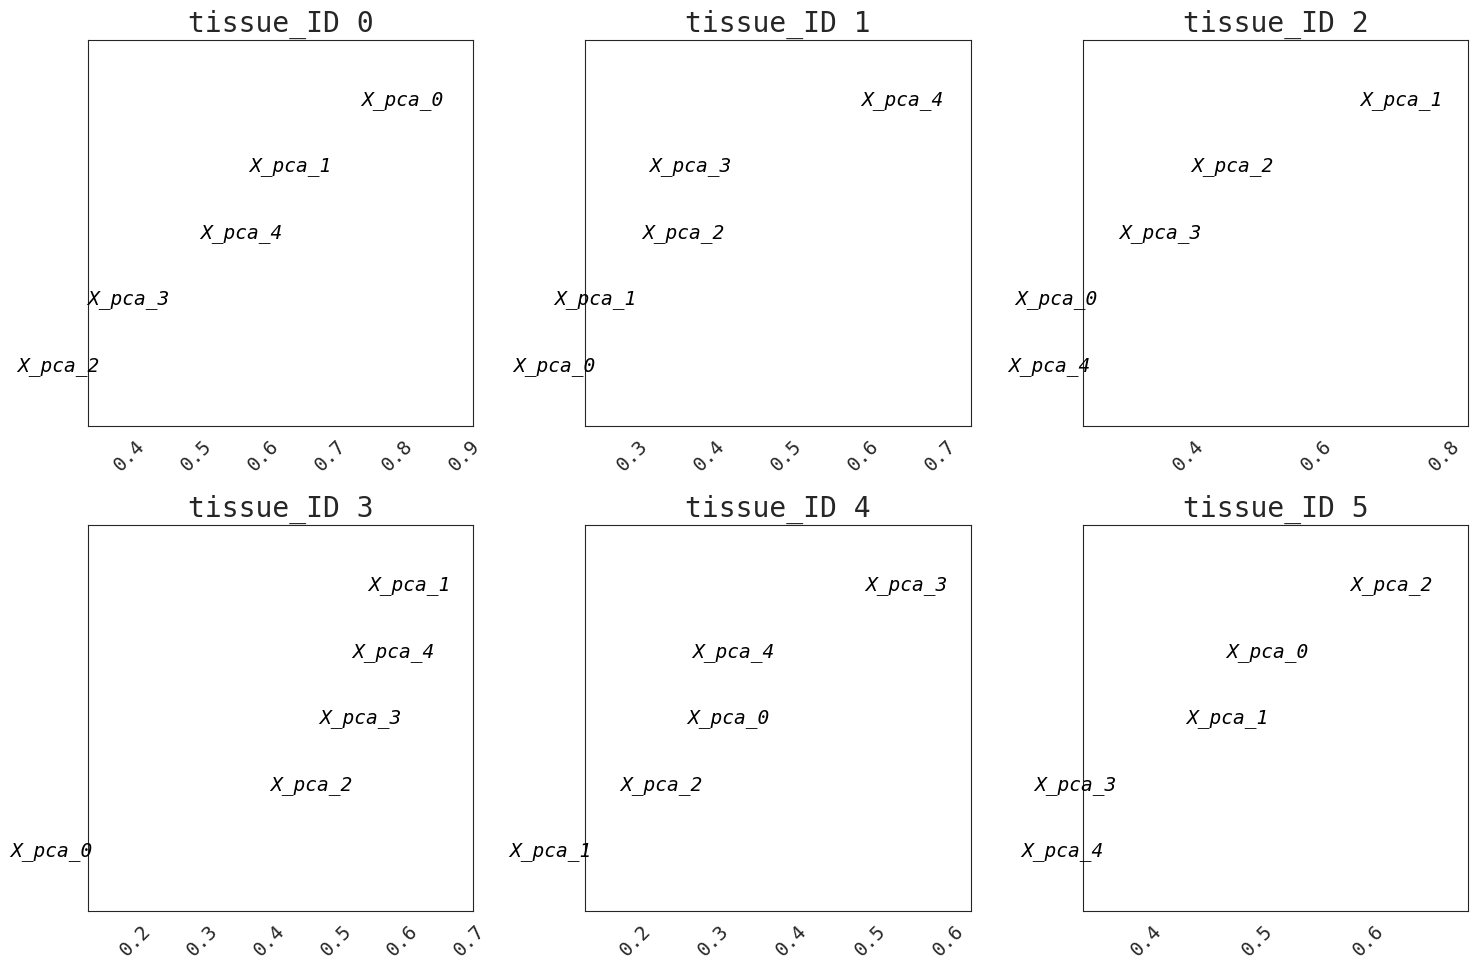

In [20]:
fl = tl.plot_feature_loadings(ncols=3)

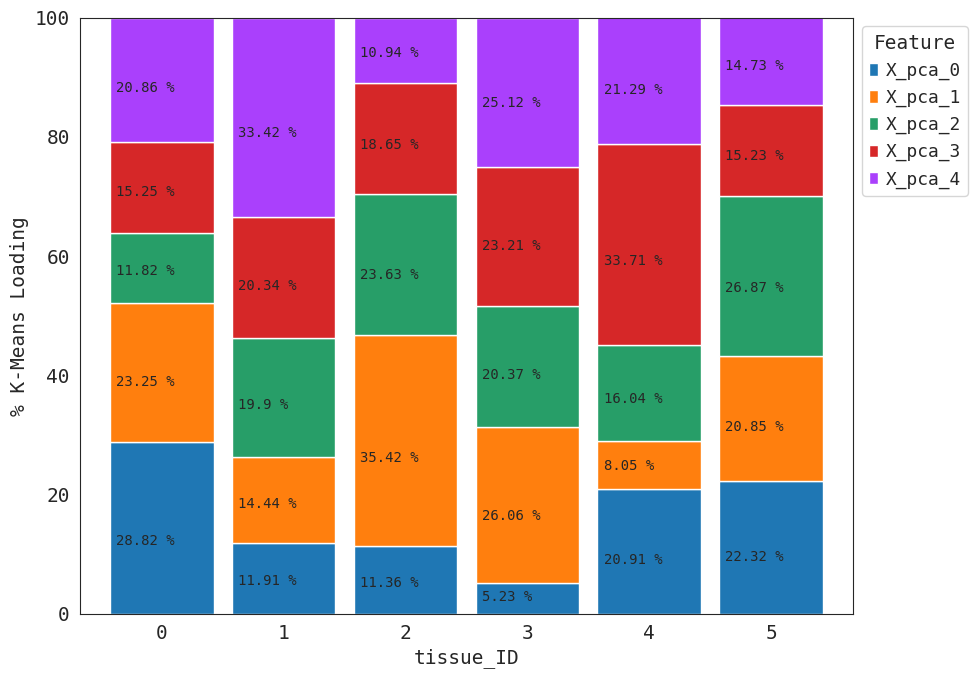

In [21]:
fp = tl.plot_feature_proportions()